# Programming Exercise 2 - Logistic Regression

In this exercise, we will implement logistic regression(Classification) and apply it to two different datasets.
We'll also improve the robustness of our implementation by adding regularization to the training algorithm. and testing it on a more difficult problem(Polynomial problems).

- [1. Logistic regression](#Logistic-regression)
- [2. Regularized logistic regression](#Regularized-logistic-regression)    

In [1]:
from __future__ import print_function, division, absolute_import
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

----------------------

## Logistic regression 

In this part of the exercise, we will build a logistic regression model to predict whether a student gets admitted into a university.Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. We have historical data from previous applicants
that we can use as a training set for logistic regression. For each training example, we have the applicant’s scores on two exams and the admissions decision.

Our task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. This outline and the framework code in [ex2.pdf](Exercise_PDF/ex1.pdf) will guide us through the exercise.

* __`Loading data`__

Load Function

In [2]:
def loadData(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    #print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

#Pandas is better for datas so later
# def loadData(file, delimeter):
#     data = pd.read_csv('data/ex2data1.txt', header=None, names=['Exam 1', 'Exam 2', 'Admitted'])

In [3]:
# The first two columns contains the exam scores and the third column contains the label.
print(' ','Exam 1','    ', 'Exam 2','   ', 'Admitted') 
data = loadData('data/ex2data1.txt', ',')

  Exam 1      Exam 2     Admitted
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


In [4]:
X = np.c_[np.ones((data.shape[0],1)), data[:,0:2]]
y = np.c_[data[:,2]] 

### **Part 1: Plotting :-** 

__`Data plot Function`__

In [5]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes = None):
    #Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    #If no specific object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)    
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon = True, fancybox = True);    

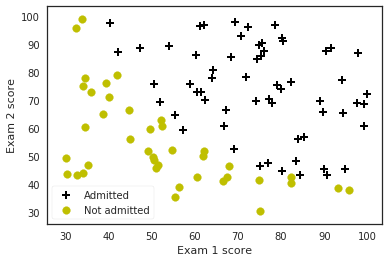

In [6]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

-----------------------

### **Part 2: Compute Cost and Gradient :-** 

* **`Logistic regression hypothesis:`**

$$ h_{\theta}(x) = g(\theta^{T}x)$$  <br>    


$$ g(z) = \frac{1}{1 + e^{-z}}    $$   
$$where, z = \theta^{T}x $$ 

>`Warmup exercise: sigmoid function: g(z)`

In [7]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

* **`Cost Function:`**

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[(-y^{(i)})\,log\,(h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$


`Vectorized Form:`
$$J(\theta) = \frac{1}{m}\big[(-y^T\,log\,(h))-(1-y)^T\,log\,(1-h)] $$

$$where, h = g(X\theta) = sigmoid(X\theta)$$


In [8]:
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

* __`Gradient Function - Partial derivative:`__

$$ gradient = \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} (h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$

`Vectorized Form:`
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}X^T(h-y)        $$

$$where, h = g(X\theta) $$

Note: grad should have the same dimensions as theta

In [9]:
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1, 1)))
    
    grad = (1/m)*X.T.dot(h-y)
    
    return(grad.flatten())

>__`Compute and display cost and gradient with non-zero theta`__

In [10]:
initial_theta = np.zeros(X.shape[1])
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Cost: ', cost)
print('\n Grad: ', grad)

Cost:  0.6931471805599453

 Grad:  [ -0.1        -12.00921659 -11.26284221]


-----------------

### **Part 3: Optimize cost function :-**

Concretely, we are going to use `minimize()` function from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize) library to find the best parameters θ for the logistic regression cost function, given a fixed dataset (of X and y values). 
We will pass to fminunc the following inputs:

* The initial values of the parameters we are trying to optimize.

* A function that, when given the training set and a particular θ, computes the logistic regression cost and gradient with respect to θ for the dataset(X, y)

In [11]:
res = minimize(costFunction, initial_theta, args=(X,y), method=None, jac=gradient, options={'maxiter':400})
res

/home/vijendra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/vijendra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


      fun: 0.2034977015895099
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557618e-09,  4.36433488e-07, -1.39671757e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])

------------------------

### **Part 4: Predict  and Accuracy :-**
__`Evaluating logistic regression`__

In [12]:
#Predict whether the label is 0 or 1 using learned logistic regression parameters theta
#It computes the predictions for X using a threshold at 0.5 (i.e., if sigmoid(theta'*x) >= 0.5, predict 1)

def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

In [13]:
# Student with Exam 1 score 45 and Exam 2 score 85 we predict admission
# Predict using the optimized Theta values from above (res.x)

print('Probability:')
sigmoid(np.array([1, 45, 85]).dot(res.x.T))

Probability:


0.7762903249331021

In [14]:
#Compute accuracy on our training set

p = predict(res.x, X) 
print('Train accuracy {}%'.format(100*sum(p == y.ravel())/p.size))

Train accuracy 89.0%


-------------------

### **Part 5: Decision boundary :-** 

__`Training data with decision boundary`__

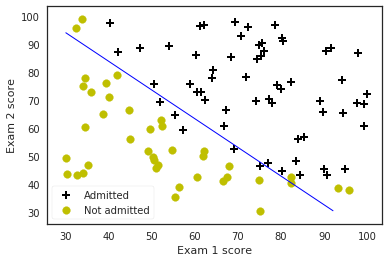

In [15]:
#plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)

plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

--------------------------
--------------------------

## Regularized logistic regression

In this part of the exercise, we will implement `regularized logistic regression(classification)` to `predict` whether `microchips` from a fabrication plant passes `quality assurance (QA)`. During QA, each microchip goes through various tests to ensure it is functioning correctly.Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be a`acepted` or `rejected`. To help you make the decision, We have a dataset of test results on past microchips, from which we can build a logistic regression model.

We will use another script, [ex2 reg.m](Exercise_PDF/ex2_reg.pdf) to complete this portion of the exercise.

* __`Loading data`__

In [16]:
#The first two columns contains the X values and the third column contains the label (y).
data2 = loadData('data/ex2data2.txt', ',')

[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [17]:
X = data2[:,0:2]
y = np.c_[data2[:,2]]

### __Part 1: Plotting data__

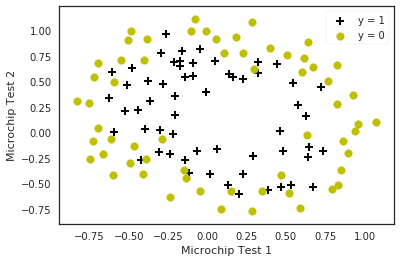

In [18]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

`In this part, we are given a dataset with data points that are not linearly separable. However, we would still like to use logistic regression to classify the data points. To do so, we introduce more features to use -- in particular, we add polynomial features to our data matrix (similar to polynomial regression)`.

----------------------------------

### __Part 2: Adding Polynomial Features__    __[Ref: here](http://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features)__

>`Note that PolynomialFeatures() function  also adds a column of ones for us, so the intercept term is handled`

In [19]:
poly = PolynomialFeatures(6)
XX = poly.fit_transform(data2[:,0:2])
XX.shape

(118, 28)

While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, we will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

------------------------------------

### __Part 3: Compute Regularized cost function and gradient__

* **`Regularized cost function`**

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
 
`vectorized form:`

$$ J(\theta) = \frac{1}{m}\big((\,log\,(h)^Ty+(\,log\,(1-h)^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

$$where, h = g(X\theta) $$

In [1]:
def costFunctionReg(theta, reg, *args):        # *args useful for siblings, e.g:-like XX,y, and so on 
    m = y.size
    h = sigmoid(XX.dot(theta))

    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + \
        (reg/(2*m))*np.sum(np.square(theta[1:]))

    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

* **`Regularized gradient function: Partial derivative`** 

 $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 

`Vectorized form:`

$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$


$$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [2]:
def gradientReg(theta, reg, *args):           # *args useful for siblings, e.g:-like XX, y, and so on 
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1, 1)))

    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]], theta[1:].reshape(-1, 1)]

    return(grad.flatten())

In [3]:
# Initialize fitting parameters
initial_theta = np.zeros(XX.shape[1])

# Set regularization parameter lambda to 1
regparm_lambda = 1

# Compute and display initial cost and gradient for regularized logistic regression
cost     =  costFunctionReg(initial_theta, regparm_lambda, XX, y)
gradient =  gradientReg(initial_theta, regparm_lambda, XX, y)

print('Cost at initial theta (zeros):', cost, '\n')
print('Gradient at initial theta (zeros) - first five values only:','\n', gradient)

NameError: name 'np' is not defined

### Part 4: Optimization, Regularization and Accuracies :-

`Optional Exercise:`

In this part, we will get to try different values of lambda and see 
> `How regularization affects the decision boundary?`

Try the following values of lambda (0, 1, 10, 100).
> `How does the decision boundary change when we vary lambda?` 

> `How does the training set accuracy vary?`

Similar to the previous parts, you will use `minimize()` function from `scipy.optimize` to learn the optimal parameters θ

/home/vijendra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


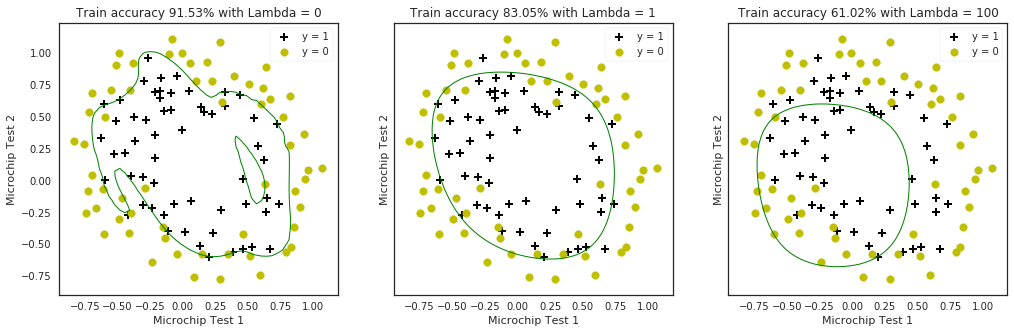

In [26]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimize costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, 
                    options={'maxiter':3000})
    
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))

<`Thank you: Happy Machine Learning with Python`>